In [68]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [69]:
#reading the data
df = pd.read_excel('teste_prophet.xlsx')

In [70]:
df.head()

,intervalo,ligacoes
0,2019-01-02 08:00:00,13
1,2019-01-02 08:30:00,9
2,2019-01-02 09:00:00,21
3,2019-01-02 09:30:00,44
4,2019-01-02 10:00:00,60


In [71]:
df.set_index('intervalo', inplace=True)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29864 entries, 2019-01-02 08:00:00 to 2021-10-29 10:30:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ligacoes  29864 non-null  int64
dtypes: int64(1)
memory usage: 466.6 KB


<AxesSubplot:xlabel='intervalo'>

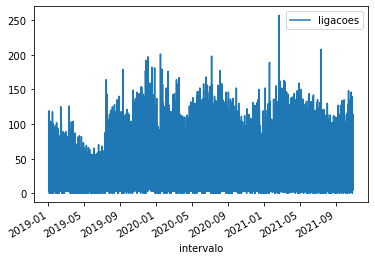

In [73]:
#this is the overall graphic of how the data behaves from 2019 til oct/2021
df.plot()

In [74]:
df.reset_index(inplace=True)

In [75]:
#detecting outliers
def detect_outliers(df, n, features):

    outlier_indices = []

    for col in features:

        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)

        IQR = Q3 - Q1
        print('\n',col)

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        print(outlier_list_col)
        outlier_indices.extend(outlier_list_col)
    
    return outlier_indices

In [76]:
#removing those outliers (below Q1 and above Q3)
lof = ['ligacoes']
daily_prices_tkm = df[['intervalo','ligacoes']]
Outliers_to_drop = detect_outliers(daily_prices_tkm, 1, lof)
daily_prices_tkm.drop(Outliers_to_drop,inplace=True)

y = df['ligacoes']
size = len(df['intervalo'])

print("Turkey Method, " + str(100-((y[Outliers_to_drop].size/size)*100)) +  " % of remained data points from Dataset.")


 ligacoes
Int64Index([ 5597,  5602,  5625,  5626,  5657,  5691,  6843,  7220,  8234,
             8643,
            ...
            25449, 25507, 25925, 26675, 26677, 26678, 29398, 29404, 29665,
            29747],
           dtype='int64', length=200)
Turkey Method, 99.33029734797749 % of remained data points from Dataset.


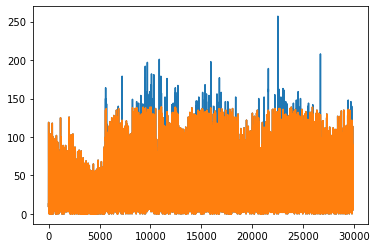

In [77]:
#graphic of the difference between the original data and the one without outliers
df['ligacoes'].plot().get_figure()
daily_prices_tkm['ligacoes'].plot().get_figure()
plt.show()

In [78]:
def adf_test(dataset):
    ds = dataset
    
    alpha = 0.05
    
    result = adfuller(ds, autolag='AIC')
    print('Augmented Dickey-Fuller Test')
    print('test statistic: %.10f' % result[0])
    print('p-value: %.10f' % result[1])
    print('critical values')
    
    for key, value in result[4].items():
        print('\t%s: %.10f' % (key, value))
        
    if result[1] < alpha:  #alpha being equal to 0.05
        print("Rejecting it")
    else:
        print("Fail to reject")
        
adf_test(daily_prices_tkm['ligacoes'])

Augmented Dickey-Fuller Test
test statistic: -17.4868764046
p-value: 0.0000000000
critical values
	1%: -3.4305708221
	5%: -2.8616375973
	10%: -2.5668219481
Rejecting it


In [79]:
daily_prices_tkm.head()

,intervalo,ligacoes
0,2019-01-02 08:00:00,13
1,2019-01-02 08:30:00,9
2,2019-01-02 09:00:00,21
3,2019-01-02 09:30:00,44
4,2019-01-02 10:00:00,60


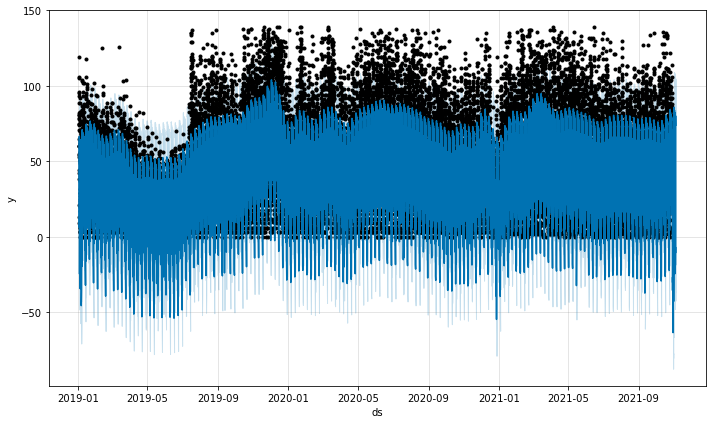

In [81]:
#predicting without the outliers, and with all the available data. I forgot to mention but we are dealing with data that has a 30 min interval
df_prophet = daily_prices_tkm[['intervalo','ligacoes']]
df_prophet.columns = ['ds','y']
m = Prophet().fit(df_prophet)
future = m.make_future_dataframe(periods=300, freq='30min')
fcst = m.predict(future)
fig = m.plot(fcst)

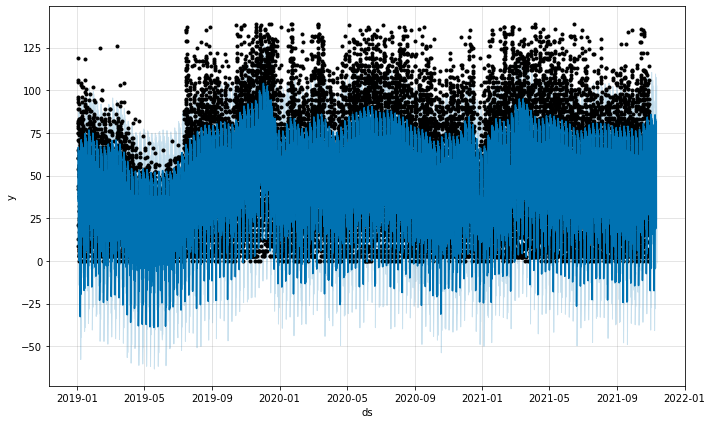

In [148]:
#the df contains only data from 8 til 23h, so I added this restriction for the prediction and improved a little bit the values, but still gettin negative values
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour > 8]
future2 = future2[future2['ds'].dt.hour < 23]
fcst = m.predict(future2)
fig = m.plot(fcst)

In [82]:
#this is the data with outliers, which I also tested
df.columns = ['ds','y']

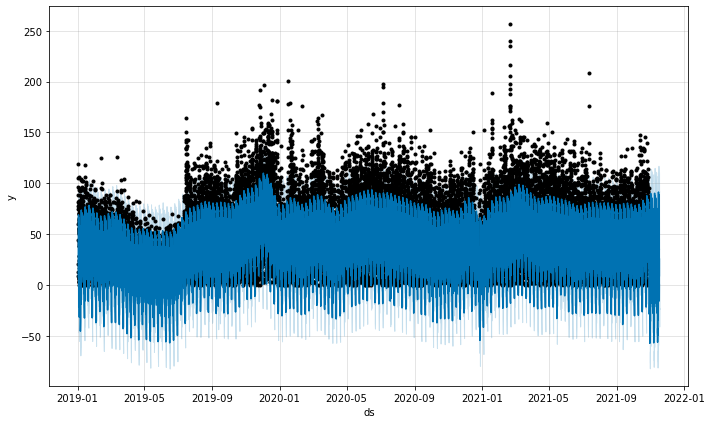

In [83]:
m = Prophet().fit(df)
future = m.make_future_dataframe(periods=900, freq='30min')
fcst = m.predict(future)
fig = m.plot(fcst)

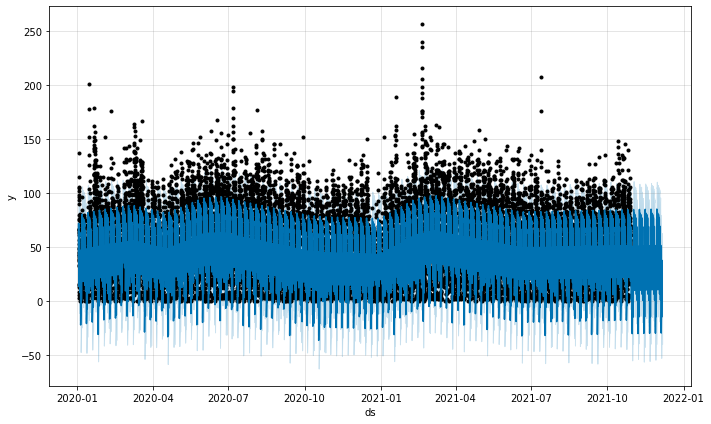

In [154]:
#applying the filter on the data with outliers
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour > 8]
future2 = future2[future2['ds'].dt.hour < 23]
fcst = m.predict(future2)
fig = m.plot(fcst)

#### test with values only from 2021

<AxesSubplot:>

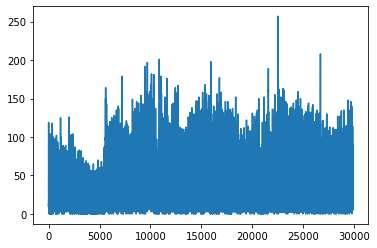

In [84]:
df['y'].plot()

In [85]:
df = pd.read_excel('teste_prophet (1).xlsx')

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8782 entries, 0 to 8781
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   intervalo  8782 non-null   datetime64[ns]
 1   ligacoes   8782 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 137.3 KB


In [90]:
df.columns = ['ds','y']

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


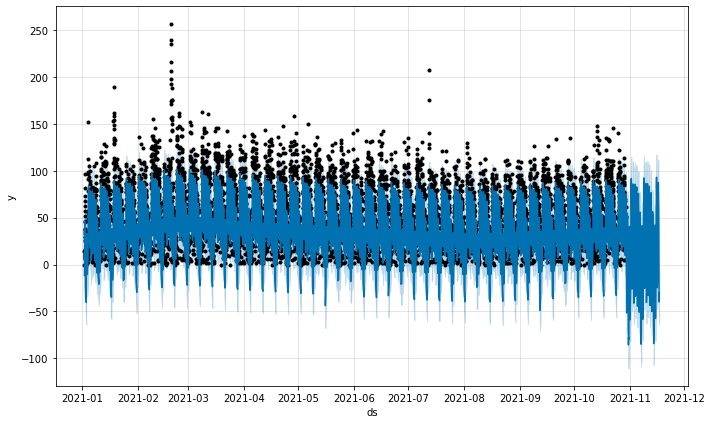

In [91]:
#here we can visualize the data better, it seems that prophet can't seem to fit properly the daily seasonality, the value needs to be higher than the predicted now (the weekly is just fine)
m = Prophet().fit(df)
future = m.make_future_dataframe(periods=900, freq='30min')
fcst = m.predict(future)
fig = m.plot(fcst)

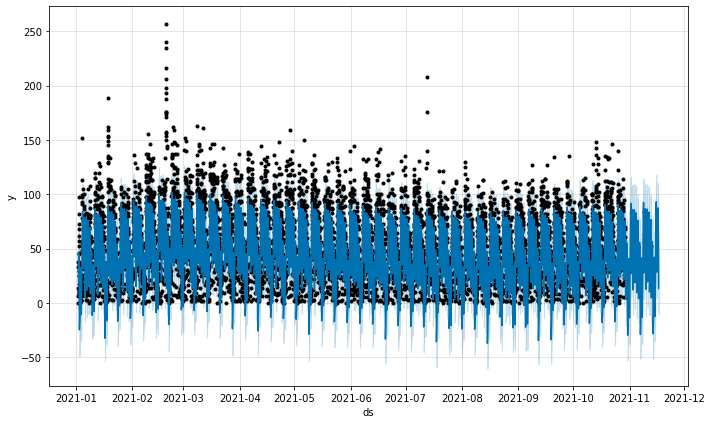

In [92]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour > 8]
future2 = future2[future2['ds'].dt.hour < 23]
fcst = m.predict(future2)
fig = m.plot(fcst)

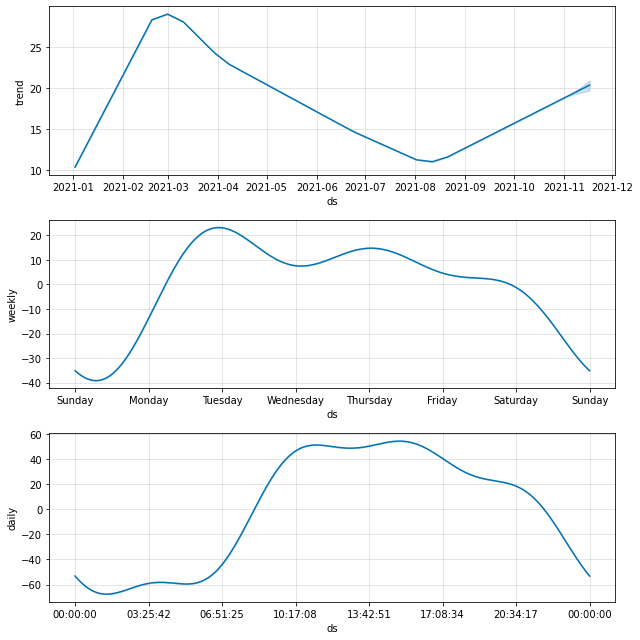

In [93]:
fig = m.plot_components(fcst)

#### using data only from august 2021 ahead

In [94]:
df = pd.read_excel('teste_prophet (2).xlsx')

In [95]:
df.head()

,intervalo,ligacoes
0,2021-08-01 08:00:00,4
1,2021-08-01 08:30:00,5
2,2021-08-01 09:00:00,9
3,2021-08-01 09:30:00,12
4,2021-08-01 10:00:00,12


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2613 entries, 0 to 2612
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   intervalo  2613 non-null   datetime64[ns]
 1   ligacoes   2613 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 41.0 KB


In [97]:
df.columns = ['ds', 'y']

In [98]:
df.set_index('ds', inplace=True)

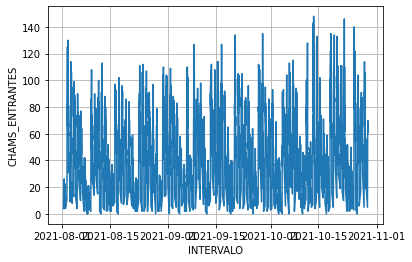

In [99]:
#here you can see the daily peaks better. It differs from week to week, doesn't have a strict pattern, maybe this is why the prediction is poor?
plt.plot(df.index, df.y)
plt.xlabel('INTERVALO', fontsize = 10)
plt.ylabel('CHAMS_ENTRANTES',fontsize = 10)
plt.grid()

In [8]:
ts = df['y']
print(ts)

ds
2021-08-01 08:00:00     4
2021-08-01 08:30:00     5
2021-08-01 09:00:00     9
2021-08-01 09:30:00    12
2021-08-01 10:00:00    12
                       ..
2021-10-29 08:30:00    22
2021-10-29 09:00:00    37
2021-10-29 09:30:00    68
2021-10-29 10:00:00    70
2021-10-29 10:30:00    61
Name: y, Length: 2613, dtype: int64


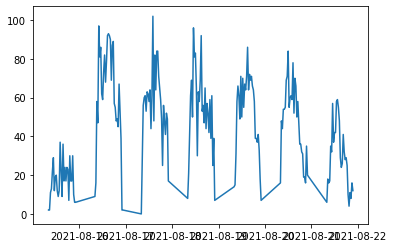

In [9]:
ts1 = ts['2021-08-15 08:00:00':'2021-08-21 22:00:00']
plt.plot(ts1)

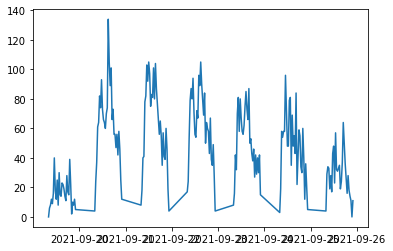

In [10]:
ts1 = ts['2021-09-19 08:00:00':'2021-09-25 22:00:00']
plt.plot(ts1)

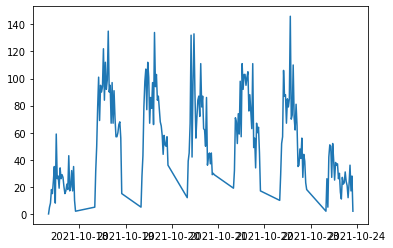

In [11]:
ts1 = ts['2021-10-17 08:00:00':'2021-10-23 22:00:00']
plt.plot(ts1)

#with these 3 graphics you can see that daily peaks are very different

In [100]:
df.reset_index(inplace=True)

In [101]:
df.head()

,ds,y
0,2021-08-01 08:00:00,4
1,2021-08-01 08:30:00,5
2,2021-08-01 09:00:00,9
3,2021-08-01 09:30:00,12
4,2021-08-01 10:00:00,12


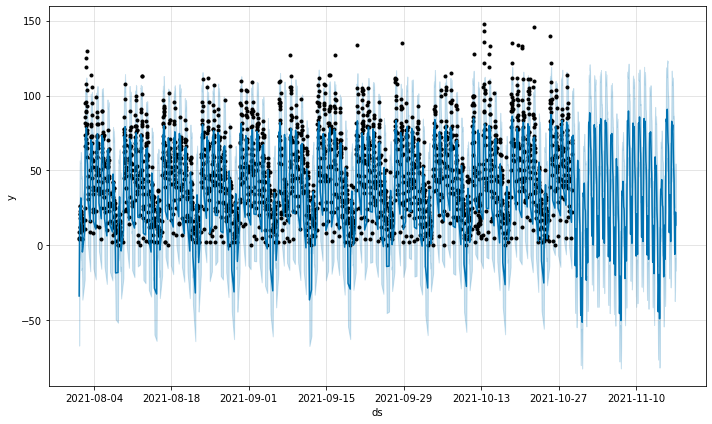

In [26]:
df2 = df.copy()
df2 = df2[df2['ds'].dt.hour >= 8]
df2 = df2[df2['ds'].dt.hour <= 23]
m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, interval_width = 0.95).fit(df2) #the interval needs to be 0.95
future = m.make_future_dataframe(periods=900, freq='30min')
fcst = m.predict(future)
fig = m.plot(fcst)

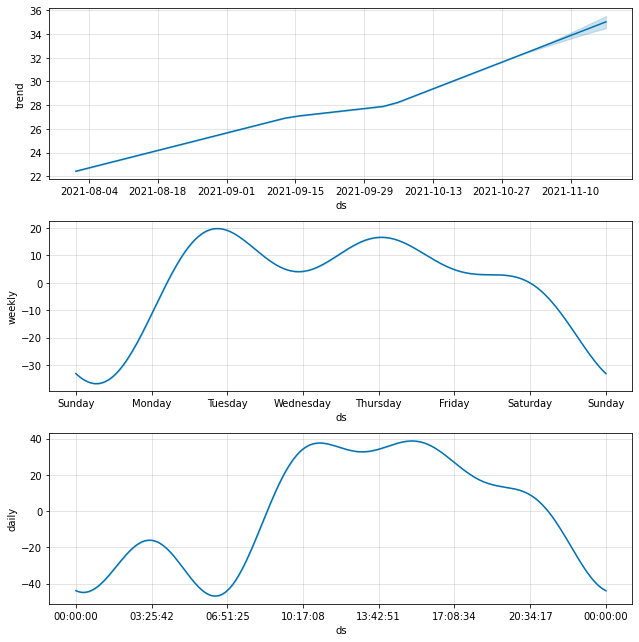

In [23]:
fig = m.plot_components(fcst)
#the weekly seasonality seems also fine, the daily needs to be higher

In [18]:
from fbprophet.diagnostics import cross_validation

cutoffs = pd.to_datetime(['2021-09-01', '2021-10-01'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='30 days')

  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
df_cv2.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
1702,2021-10-29 08:30:00,18.667523,-9.918997,47.576443,22,2021-10-01
1703,2021-10-29 09:00:00,32.881654,3.636766,64.788997,37,2021-10-01
1704,2021-10-29 09:30:00,45.179327,14.565275,74.007919,68,2021-10-01
1705,2021-10-29 10:00:00,54.109963,23.476264,85.036224,70,2021-10-01
1706,2021-10-29 10:30:00,59.115800,30.841020,89.260922,61,2021-10-01


In [21]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv2)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,2 days 20:30:00,172.209980,13.122880,10.453486,0.190795,0.970588
1,2 days 21:00:00,171.190734,13.083988,10.404604,0.190795,0.970588
2,2 days 21:30:00,171.114656,13.081080,10.398329,0.190881,0.970588
3,2 days 22:00:00,168.604155,12.984766,10.277582,0.190881,0.970588
4,2 days 22:30:00,168.327874,12.974123,10.248029,0.191745,0.970588


#### trying different ways to increase the accuracy

In [105]:
df.columns=['ds', 'y']
#this is the same data with outliers

In [106]:
df2 = df.copy()
df2 = df2[df2['ds'].dt.hour >= 8]
df2 = df2[df2['ds'].dt.hour < 23]

#applying the filter again

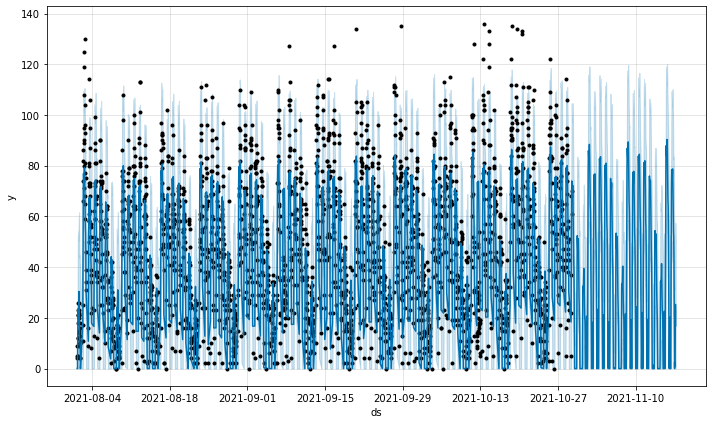

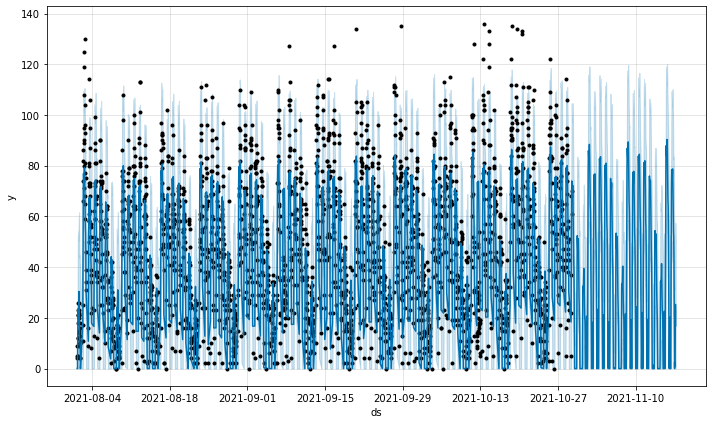

In [67]:
#i've tried to apply additional regressors. the first one is related to weekend, since the pattern is very different from weekdays

def weekend_regressors(ds):
    date = pd.to_datetime(ds)
    if date.weekday() > 5:
        return 1
    else:
        return 0

# as a way to increase the seasonality, i thought about applying an aditional regressor only for monday, as it is the day that historically has the biggest number of calls
def segunda(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 1:
        return 1
    else:
        return 0
    
df2['weekend_regressors'] = df2['ds'].apply(weekend_regressors)
df2['segunda'] = df2['ds'].apply(segunda)

m = Prophet(yearly_seasonality=False, weekly_seasonality=True, interval_width = 0.95)
m.add_regressor('weekend_regressors')
m.add_regressor('segunda')
m.fit(df2)

future['weekend_regressors'] = future['ds'].apply(weekend_regressors)
future['segunda'] = future['ds'].apply(segunda)

forecast = m.predict(future)

#as i can't have negative values, i clipped them into 0 (which didn't seem to be a good strategy)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = forecast[col].clip(lower=0.0)
    
m.plot(forecast)

In [58]:
from fbprophet.diagnostics import cross_validation

cutoffs = pd.to_datetime(['2021-09-01', '2021-10-01'])
df_cv2 = cross_validation(my_model, cutoffs=cutoffs, horizon='30 days')

  0%|          | 0/2 [00:00<?, ?it/s]

In [59]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv2)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,2 days 20:30:00,149.777937,12.238380,9.513500,0.187101,0.964706
1,2 days 21:00:00,150.150169,12.253578,9.545424,0.187101,0.964706
2,2 days 21:30:00,150.135410,12.252976,9.556425,0.188018,0.964706
3,2 days 22:00:00,147.254092,12.134830,9.402373,0.187101,0.964706
4,2 days 22:30:00,146.769766,12.114857,9.357831,0.188018,0.964706


In [36]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,V0,V0_lower,V0_upper,V1,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-08-01 08:00:00,19.952521,0.0,10.289539,19.952521,19.952521,0.493611,0.493611,0.493611,-0.040298,...,6.843811,6.843811,6.843811,-24.781963,-24.781963,-24.781963,0.0,0.0,0.0,0.000000
1,2021-08-01 08:30:00,19.954515,0.0,22.724418,19.954515,19.954515,0.511361,0.511361,0.511361,-0.035668,...,3.522449,3.522449,3.522449,-24.785534,-24.785534,-24.785534,0.0,0.0,0.0,0.000000
2,2021-08-01 09:00:00,19.956508,0.0,34.419615,19.956508,19.956508,0.526901,0.526901,0.526901,-0.030887,...,0.206182,0.206182,0.206182,-24.753305,-24.753305,-24.753305,0.0,0.0,0.0,5.227086
3,2021-08-01 09:30:00,19.958502,0.0,47.561043,19.958502,19.958502,0.540164,0.540164,0.540164,-0.025974,...,-3.049305,-3.049305,-3.049305,-24.684969,-24.684969,-24.684969,0.0,0.0,0.0,15.220920
4,2021-08-01 10:00:00,19.960496,0.0,52.613836,19.960496,19.960496,0.551094,0.551094,0.551094,-0.020950,...,-6.189293,-6.189293,-6.189293,-24.580308,-24.580308,-24.580308,0.0,0.0,0.0,21.965142


In [39]:
y_true = df2['y'].values
y_pred = forecast['yhat'].values

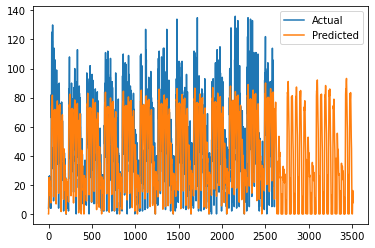

In [40]:
from matplotlib import pyplot
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

#here you can see better the difference between actual and predicted values

In [18]:
from fbprophet.diagnostics import cross_validation

cutoffs = pd.to_datetime(['2021-09-01', '2021-10-01'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='30 days')

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv2)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,2 days 20:30:00,173.045890,13.154691,10.467573,0.188357,0.970588
1,2 days 21:00:00,172.024969,13.115829,10.417529,0.188357,0.970588
2,2 days 21:30:00,171.965924,13.113578,10.415214,0.191481,0.970588
3,2 days 22:00:00,169.485718,13.018668,10.293749,0.191481,0.970588
4,2 days 22:30:00,169.193568,13.007443,10.261854,0.193375,0.970588


In [110]:
df2 = df.copy()
df2 = df2[df2['ds'].dt.hour >= 8]
df2 = df2[df2['ds'].dt.hour < 23]

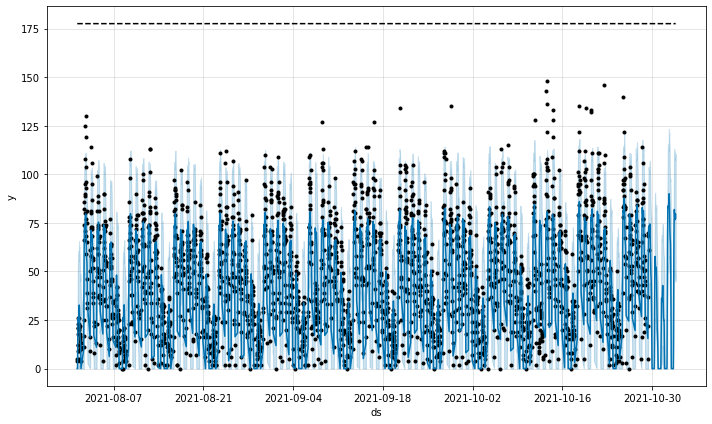

In [111]:
#another strategy was applying logistic trend, but still, no big improvements

# Fit a logistic growth model, and clip
df2['cap'] = 1.2 * df2['y'].max()
m = Prophet(
    growth='logistic',
    yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, interval_width = 0.95,
).fit(df2)
future = m.make_future_dataframe(203, freq='30min')
future['cap'] = 1.2 * df2['y'].max()
fcst = m.predict(future)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    fcst[col] = fcst[col].clip(lower=0.0)
fig = m.plot(fcst)

In [46]:
from fbprophet.diagnostics import cross_validation

cutoffs = pd.to_datetime(['2021-09-01', '2021-10-01'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='30 days')

  0%|          | 0/2 [00:00<?, ?it/s]

In [47]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv2)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,2 days 20:30:00,170.977122,13.075822,10.587429,0.205858,0.964706
1,2 days 21:00:00,170.205735,13.046292,10.554797,0.205858,0.964706
2,2 days 21:30:00,170.064102,13.040863,10.515981,0.205858,0.964706
3,2 days 22:00:00,167.242421,12.932224,10.384927,0.205858,0.964706
4,2 days 22:30:00,167.083373,12.926073,10.355765,0.205858,0.964706


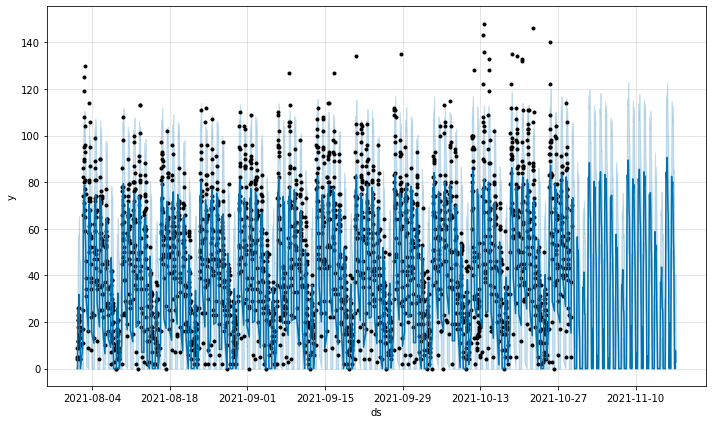

In [113]:
#and lastly i've tried the prophet pos

class ProphetPos(Prophet):
    
    @staticmethod
    def piecewise_linear(t, deltas, k, m, changepoint_ts):
        """Evaluate the piecewise linear function, keeping the trend
        positive.
        
        Parameters
        ----------
        t: np.array of times on which the function is evaluated.
        deltas: np.array of rate changes at each changepoint.
        k: Float initial rate.
        m: Float initial offset.
        changepoint_ts: np.array of changepoint times.
        
        Returns
        -------
        Vector trend(t).
        """
        # Intercept changes
        gammas = -changepoint_ts * deltas
        # Get cumulative slope and intercept at each t
        k_t = k * np.ones_like(t)
        m_t = m * np.ones_like(t)
        for s, t_s in enumerate(changepoint_ts):
            indx = t >= t_s
            k_t[indx] += deltas[s]
            m_t[indx] += gammas[s]
        trend = k_t * t + m_t
        if max(t) <= 1:
            return trend
        # Add additional deltas to force future trend to be positive
        indx_future = np.argmax(t >= 1)
        while min(trend[indx_future:]) < 0:
            indx_neg = indx_future + np.argmax(trend[indx_future:] < 0)
            k_t[indx_neg:] -= k_t[indx_neg]
            m_t[indx_neg:] -= m_t[indx_neg]
            trend = k_t * t + m_t
        return trend

    def predict(self, df=df2):
        fcst = super().predict(df)
        for col in ['yhat', 'yhat_lower', 'yhat_upper']:
            fcst[col] = fcst[col].clip(lower=0.0)
        return fcst
    
# Fit the ProphetPos model
m = ProphetPos(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, interval_width = 0.95).fit(df2)
future = m.make_future_dataframe(900, freq='30min')
fcst = m.predict(future)
fig = m.plot(fcst)

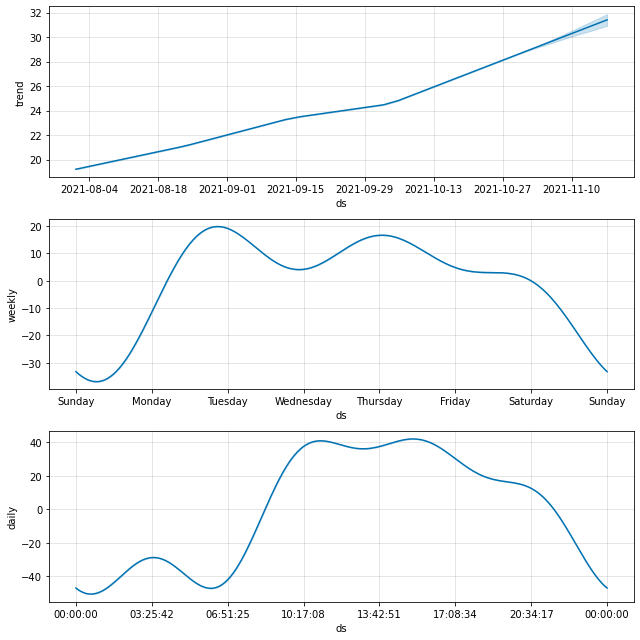

In [114]:
fig = m.plot_components(fcst)

In [11]:
from fbprophet.diagnostics import cross_validation

cutoffs = pd.to_datetime(['2021-09-01', '2021-10-01'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='30 days')

  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv2)
df_p.head()

#mae: It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight
#rmse  It’s the square root of the average of squared differences between prediction and actual observation. Dá mais peso para outliers.

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,2 days 20:30:00,159.900403,12.645173,10.062930,NaN,0.970588
1,2 days 21:00:00,158.881157,12.604807,10.014048,NaN,0.970588
2,2 days 21:30:00,158.805078,12.601789,10.007773,NaN,0.970588
3,2 days 22:00:00,156.209884,12.498395,9.879515,NaN,0.970588
4,2 days 22:30:00,155.933603,12.487338,9.849962,NaN,0.970588


In [ ]:
I h